# Time Series Project - Karl Merisalu

This project will focus on analysing historical Bitcoin (BTC) price data with simple ARIMA (Autoregressive Integrated Moving Average) model. I will train the model based on historical data and then use it to make predictions for future prices.

I've chosen this dataset because it is freely available and it would be interesting from personal perspective to apply time series methods to bitcoin price data.

Given the simplicity of the model, irrationality of Bitcoin prices and inefficiencies of Bitcoin exchanges, I don't expect the model to be highly accurate. Instead, this exercise will focus on showing how one could perform ARIMA time series analysis and predictions. 

## 1) Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## 2) Loading data

The data is downloaded from http://www.cryptodatadownload.com. I'm going to use daily BTC closing prices data in USD from Kraken exchange, which will result in 5-6 years of daily prices.


In [2]:
df = pd.read_csv('Kraken_BTCUSD_d.csv', skiprows=1) # skipping 1st row which includes unnecessary data.
df.head(3)

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2019-06-18,BTCUSD,9335.0,9355.0,9290.0,9319.7,158.46,1.476590e+06
1,2019-06-17,BTCUSD,8976.1,9470.0,8971.9,9335.0,8437.29,7.811025e+07
2,2019-06-16,BTCUSD,8856.8,9390.0,8456.0,8976.1,12551.79,1.140681e+08


## 3) Preparing and cleaning data

We will be using only Date and Close (closing price) data, because Closing Price data is used for such analyses as a stadard. But first let's find out if we need to format data and check if we have any missing values in the dataset.

It may be interesting to also conduct time series analysis on trading volume data, however, this is out of scope for this project.

In [3]:
df.dtypes # checking data types

Date           object
Symbol         object
Open          float64
High          float64
Low           float64
Close         float64
Volume BTC    float64
Volume USD    float64
dtype: object

In [4]:
df.isnull().values.any() # checking if there are any missing values

False

<b>Comment:</b> the dataset seems to be quite clean as there are no missing values. We do need to chance Date column to datetime format in order to perform time series analysis.

<b>Next,</b> we import datetime in order to start converting data from dataframe to a series (we want "date" column to be the "index" essentially)

In [5]:
from datetime import datetime

In [6]:
# setting date column to datetime value and setting it as index value
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-18,BTCUSD,9335.0,9355.0,9290.0,9319.7,158.46,1.476590e+06
2019-06-17,BTCUSD,8976.1,9470.0,8971.9,9335.0,8437.29,7.811025e+07
2019-06-16,BTCUSD,8856.8,9390.0,8456.0,8976.1,12551.79,1.140681e+08
2019-06-15,BTCUSD,8694.0,8912.0,8620.3,8856.8,5294.14,4.639254e+07
2019-06-14,BTCUSD,8237.6,8740.0,8175.0,8694.0,7258.26,6.131792e+07


Now that we have Date as index, we will create a new dataset with only date and Close columns to simplify further analysis.

In [7]:
# assigning Closing price column to a new times series variable
ts_close = df['Close']
type(ts_close)

pandas.core.series.Series

<b>Note</b> that the type if the dataset is now "Series". This is because we have date as index in the correct format.

In [8]:
ts_close.head()

Date
2019-06-18    9319.7
2019-06-17    9335.0
2019-06-16    8976.1
2019-06-15    8856.8
2019-06-14    8694.0
Name: Close, dtype: float64

<b>Next,</b> let's take a quick look at the distribution of prices..

In [9]:
ts_close.describe()

count     2070.000000
mean      2685.903754
std       3437.494834
min        122.000000
25%        409.595000
50%        685.925000
75%       4257.425000
max      19356.900000
Name: Close, dtype: float64

Interestingly we have max price way above the 75% distribution. This suggests that we have some short term spikes in the dataset, which we can confirm with plotting the data. 

Ideally, we would want the data to be following similar patterns over time and avoid one off extreme datapoints...

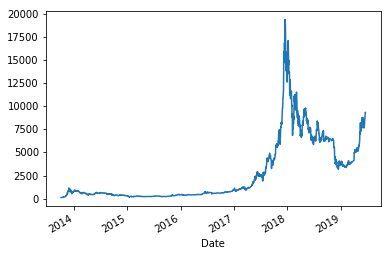

In [10]:
ts_close.plot()

<b>Comment:</b> extreme outliers confirmed!

<b>Next,</b> we will work on decomposing data to identify trend, seasonality and residual information. 

We will first give it a try with the full dataset, however, based on the above time series chart, I would expect we need slice the data to analyse a more stable (stationary) period. 2014-2016 perhaps...

## 4) Decomposition of data

We will be using seasonal_decompose library to decompose data into 3: 

<br>1) Trend (The general direction data is travelling (like upwards or downwards) 
<br>2) Seasonality (Cycles that we could see repeating in the data) 
<br>3) Noise (The random variation that occurs naturally in the data)

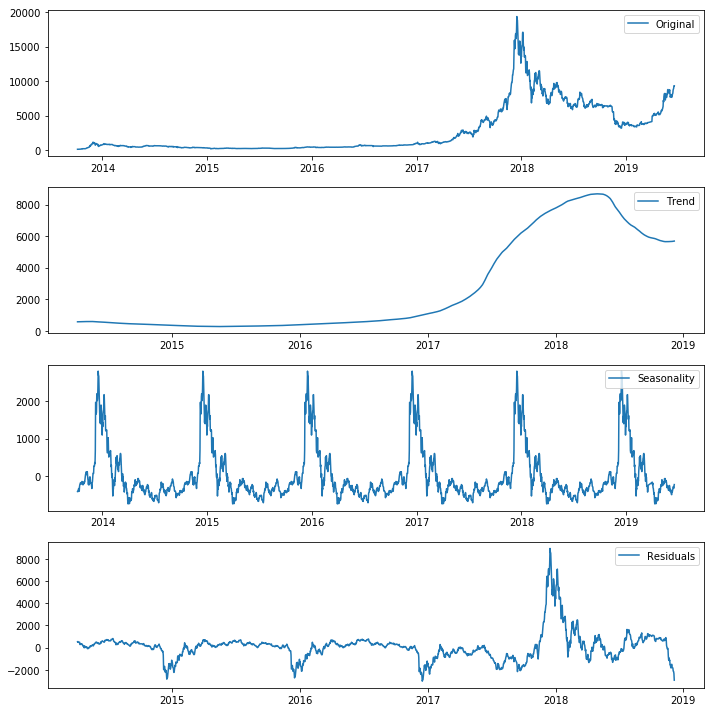

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_close, freq=365)

# creating 3 new variables of decomposed parts
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))

plt.subplot(411)
plt.plot(ts_close, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

<b>Note on the above:</b> Clearly, the pre-2017 times, 2017-2018 crypto boom and post boom times are very different in nature and hence difficult to analyse together with the same algorithm. Hence we split the series into more similar periods. As an example we will analyse year 2015 and try to make predictions for 2016.

In [12]:
ts_close_2015 = ts_close[df.index.year == 2015]
ts_close_2015.head()

Date
2015-12-31    431.31
2015-12-30    424.31
2015-12-29    430.95
2015-12-28    418.78
2015-12-27    426.04
Name: Close, dtype: float64

In [13]:
ts_close_2015.describe()

count    365.000000
mean     272.221123
std       58.417448
min      175.000000
25%      234.150000
50%      250.000000
75%      285.210000
max      464.970000
Name: Close, dtype: float64

<b>Comment:</b> we can tell from the above distribution that BTC prices in 2015 are definitely more stable than compared to the full period.

Next, we run the same decomposing algorithms on BTC 2015 price data

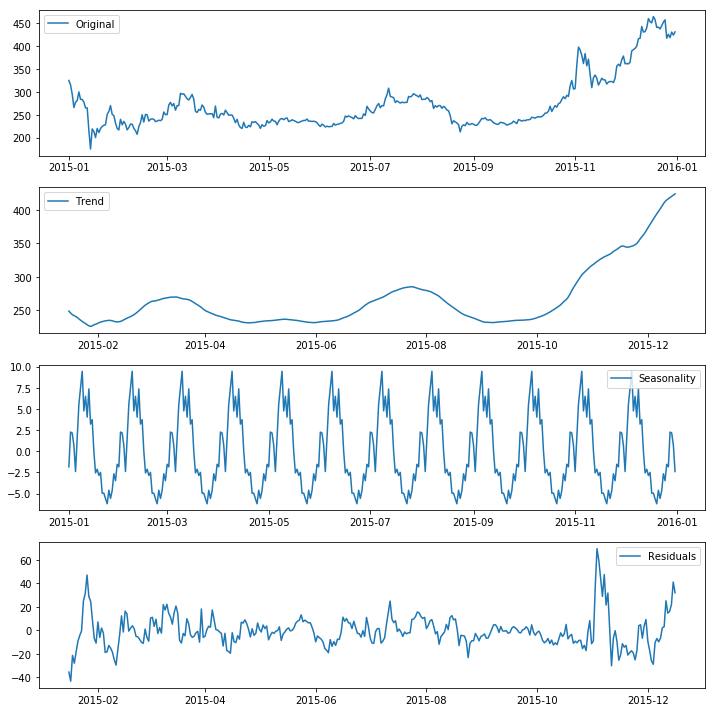

In [14]:
# running the same decomposing method for year 2015 data
decomposition = seasonal_decompose(ts_close_2015, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))

plt.subplot(411)
plt.plot(ts_close_2015, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

## 5) Model and transform

In order to build a valid model, we need to make sure that data is stationary - that it's mean, variance and covariance are constant over time. 

<b>Our 0-hypothesis is the following: BTC price data is not significantly different from 0.  </b> According to this, if we determine that BTC price is not  significantly different from 0, our data is stationary.

<b>1) If the price data is significantly different from 0, we reject 0-hypothesis </b>(and data is not stationary)

<b>2) If the price data is not significantly different from 0, we accept 0-hypothesis </b>(and data is stationary - this is what we want to achieve)

To assess this we check the <b>p-value</b>. Highler than 0.05 p-value means that chances of BTC prices being different from 0 are <b>insignificant</b> (this is what we want!)

Lower than 0.05 p-value means that chances of BTC prices being different from 0 are significant.

In [15]:
from statsmodels.tsa.stattools import kpss
kpss(ts_close_2015)

C:\Users\Karl\Desktop\datafellowship\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.9634364638463488,
 0.01,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In this case, our p-value is less than 0.05 (it is 0.01), meaning we should reject the null hypothesis (of prices NOT being different from 0). This means our data is not stationary.

We need transform our data to make it stationary

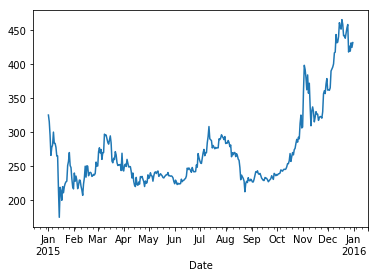

In [16]:
ts_close_2015.plot()

At the moment, our data does not have (1) constant variance or (2) contant mean. A common way to remove this changing variance is to take the natural log of all of the values in our dataset.

Taking a log of the data to remove exponsential growth (trend) and also increasing variance

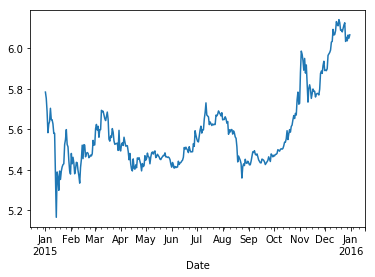

In [17]:
ts_close_2015_log = np.log(ts_close_2015)
ts_close_2015_log.plot()

Next we transform the data by taking the difference between daily prices. This should make the data points hover around 0.

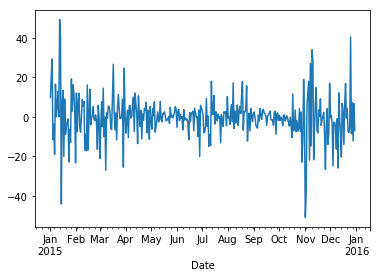

In [18]:
# now with log. differencing the data and plotting. creating a dataset of differences between the values in our dataset
ts_close_2015.diff().plot()

And now also with log. Logging, differencing the data and plotting.


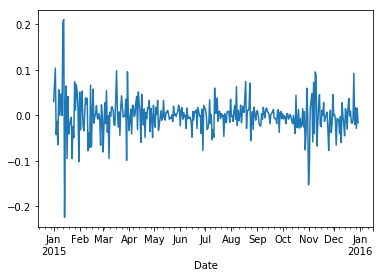

In [19]:
ts_close_2015_log.diff().plot()

Once we have transformed the data, we will check again for stationarity. (previously the p-value was <0.05)

In [20]:
# checking for stationarity again. adding drop na because now dataset has 1 less value in due to difference calculation
kpss(ts_close_2015_log.diff().dropna())

C:\Users\Karl\Desktop\datafellowship\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.33690670721869675,
 0.1,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is now greater than 0.05 (it's 0.1), so we can accept the null hypothesis that our data is stationary. 

<b>Next,</b> we will continue with time series analysis by using the transformed dataset

## 6) ARIMA Model
Autoregressive Integrated Moving Average model. More info on the model is available here: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

First, we import relevant libraries for ARIMA model"

In [21]:
# importing relevant libraries for ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

Next, we create a method to find out the MSE of the model (accuarcy)

In [22]:
# This method finds the MSE of a single ARIMA model.
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) # Needs to be an integer because it is later used as an index.
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In the next bit we create a method to run through several ARIMA models with different specs (p, d, q) and evaluate their MSE's by using the method above

In [23]:
# This method evaluates ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

<b>Next,</b> we specify the range of p, d and q values we want the methods to run through and evaluate. The larger the set of values, the longer it will take to run the algorithm as we need to train models with all value combination.

In [37]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

Finally, we run the method to find the best ARIMA model for our data (will take a while to execute)


In [42]:
# Finally, we find the best ARIMA model for our data (will take a while to execute)
import warnings
warnings.filterwarnings("ignore")
evaluate_models(ts_close_2015, p_values, d_values, q_values)

Best ARIMANone MSE=inf


We have found out that p=1, d=0 and q=0, will minimise the MSE in this ARIMA model. So we select these parameters for the model and use it to forecast future prices:

In [45]:
# selecting "best" variables for the model.
# p=1
# d=0
# q=0
p=1 # change these to see different chart fits below between predict and actual
d=0 # change these to see different chart fits below between predict and actual
q=0 # change these to see different chart fits below between predict and actual
model = ARIMA(ts_close_2015, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.predict()

In [46]:
# summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  365
Model:                     ARMA(1, 0)   Log Likelihood               -1381.045
Method:                       css-mle   S.D. of innovations             10.585
Date:                Mon, 29 Jul 2019   AIC                           2768.091
Time:                        00:23:05   BIC                           2779.790
Sample:                    12-31-2015   HQIC                          2772.740
                         - 01-01-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         308.0265     45.902      6.710      0.000     218.059     397.994
ar.L1.Close     0.9894      0.008    127.946      0.000       0.974       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0107           +0.0000j            1.0107            0.0000
-----------------------------------------------------------------------------
"""

The idea with the above would be to minimise AIC.

<br>"AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model."

## 7) Plotting the model against original data

Next we plot the model forecast against actual data:

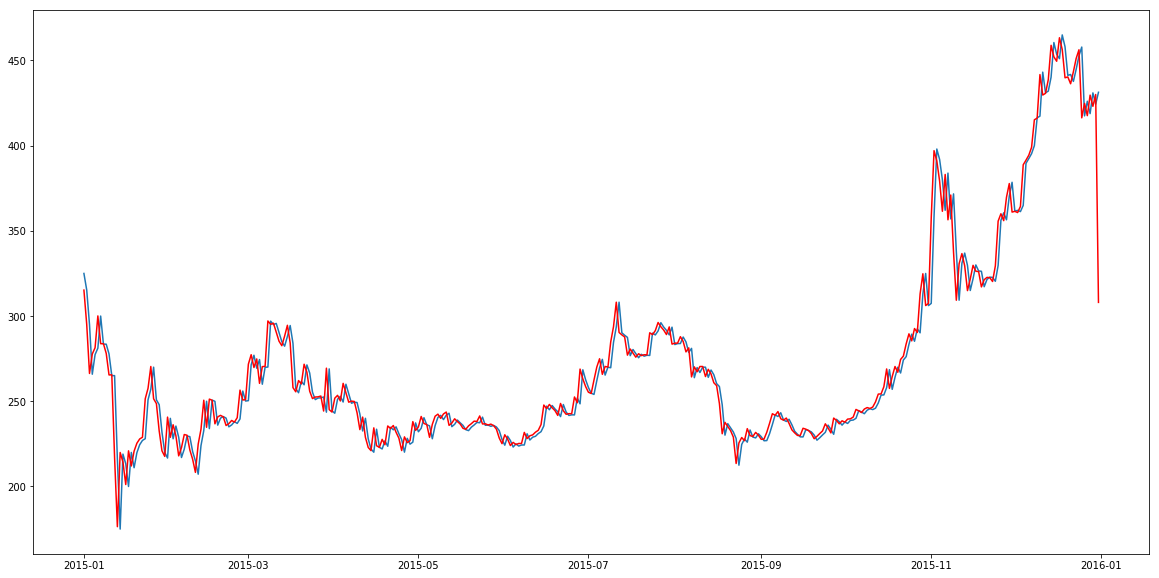

In [47]:
plt.figure(figsize=(20,10))
plt.plot(ts_close_2015)
plt.plot(model_fit.predict(), color = 'red') #p, d, q = 1, 0, 0

<b>The forecast seems accurate, but</b> it could be because it is only taking into account 1 time lag and nothing else. Essentially, the algorithm predicts BTC price to be what it was the previous day, obviously this can't be too much off from the correct price. This however, is not a very reliable method to project further ahead in the future... Let's find out by using the model to forecast and by plotting the results, 

But first, we will remove the last prediction value, as this is likely been caused by fitting the model based on lack of data in the end of the dataset 


In [48]:
forecast = forecast['2015-12-30':'2015-01-01']
forecast.head()

2015-12-30    430.001016
2015-12-29    423.075340
2015-12-28    429.644838
2015-12-27    417.604055
2015-12-26    424.786971
Freq: -1D, dtype: float64

## 8) Forecasting
In this section we will forecast bitcoin price in the future (30 days into 2016). First we create a list with additional 30 dates in the future in the same datetime format

In [49]:
periods_to_forecast = 30

In [50]:
# Creating a range of future dates that is the length of the periods I've chosen to forecast
date_range = pd.date_range(ts_close_2015.index[0], periods = periods_to_forecast,
              freq='D').strftime("%Y-%m-%d").tolist()

# Turn that range into a dataframe that includes your predictions
future_dates = pd.DataFrame(date_range, columns = ['Date'])
future_dates['Date'] = pd.to_datetime(future_dates['Date'])
future_dates.set_index('Date', inplace = True)

We add a 'Prediction' column where we forecast 30 values

In [51]:
future_dates['Prediction'] = forecast[0]

In [52]:
future_dates.head()

,Prediction
Date,
2015-12-31,430.001016
2016-01-01,430.001016
2016-01-02,430.001016
2016-01-03,430.001016
2016-01-04,430.001016


Importing also test data aka real BTC prices 30 days into 2016

In [53]:
test = ts_close['2016-02-01':'2016-01-01']
test.head()

Date
2016-02-01    372.00
2016-01-31    369.84
2016-01-30    378.00
2016-01-29    379.92
2016-01-28    379.27
Name: Close, dtype: float64

<b>Finally,</b> we plot our training data and our actual test data against our predictions...

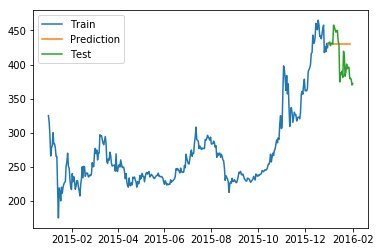

In [54]:
plt.plot(ts_close_2015, label='Train')
plt.plot(future_dates, label='Prediction')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

<b>Comment:</b> it is somewhat expected that our prediction is a straight line. This is because if the model takes into account only the the value with 1 lag (p =1, d=0, q=0). The logical best guess for next day's price would be the previous  day's price.

## 9) Evaluation
In the beginning of the project we stated that we wanted to train an ARIMA model to predict BTC prices in the future. This was always going to be a huge task for a relatively simple model and a very "volatile" dataset. 

<br>Somewhat expectedly, the most accurate model at first sight, was the model predicting the price of previous day. This works relatively well when fitting the model to the actual data, however, it is not very reliable for making long term price predictions as highlighted on the chart above. 

<br>Our prediction being a straight line makes sense based on the simple model and as explained above, however, we should look into why the.

<br><b>To sum up,</b> we have failed building a suitable model predicting BTC price in the future. It might be worth taking this topic further by introducing more sophisticated time series models like Seasonal ARIMA and others.